# DC$\pi$BO - ECON

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../src/")
sys.path.append("../..")

from src.examples.example_setups import setup_econ_SEM

from src.utils.sem_utils.real_sems import EconSEM
from src.utils.sem_utils.sem_estimate import build_sem_hat
from src.utils.gp_utils import fit_gp
from src.utils.utility_functions import *
from src.utils.plotting import plot_expected_opt_curve_paper

from src.experimental.experiments import run_methods_replicates
from src.experimental.analyse_results import get_relevant_results, elaborate, gap_metric_standard, get_common_initial_values, get_converge_trial

from src.methods.bo import BO
from src.methods.dcbo import DCBO
from src.methods.pibo import PIBO
from src.methods.dcpibo import DCPIBO

from matplotlib.pyplot import rc
import random
import pandas as pd
from copy import deepcopy
import numpy as np

random.seed(42)

## Constants and such

In [2]:
T = 3
t_axis = np.linspace(1,T,T,dtype=int)
N = 10
std = 0.1
beta = 1

## Setup

### Import and Clean Data

In [3]:
GDP = pd.read_csv('../../data/economic_data/GDP.csv')
INF = pd.read_csv('../../data/economic_data/INF.csv')
TAX = pd.read_csv('../../data/economic_data/TAX.csv')
UN = pd.read_csv('../../data/economic_data/UN.csv')

In [4]:
GDP = GDP[["LOCATION", "TIME", "Value"]]
INF = INF[["LOCATION", "TIME", "Value"]]
TAX = TAX[["LOCATION", "TIME", "Value"]]
UN = UN[["LOCATION", "TIME", "Value"]]

In [5]:
new_df1 = pd.merge(GDP, INF, how='left', on=['LOCATION','TIME'])
new_df2 = pd.merge(new_df1, TAX,  how='left', on=['LOCATION','TIME'])
new_df3 = pd.merge(new_df2, UN,  how='left', on=['LOCATION','TIME'])
new_df3.columns = ['LOC', 'TIME', 'GDP', 'INF', 'TAX', 'UN']

data = new_df3[new_df3['TIME'] > 2017]
data = data[data['TIME'] < 2023]
data = data.dropna()
data = data.reset_index(drop=True)

 /tmp/ipykernel_385/2333906969.py:3: FutureWarning:Passing 'suffixes' which cause duplicate columns {'Value_x'} in the result is deprecated and will raise a MergeError in a future version.


In [6]:
country_list = []
for i in range(10):
    time = 2018 + i
    country_list.append(list(data[data['TIME'] == time]['LOC']))

In [7]:
np.unique(data['LOC'])
data['GDP%'] = np.nan
data['log_U'] = np.nan
data['TAX%'] = np.nan

for i, row in data.iterrows():
    if i > 0:
        perc_change_GDP = ((list(data['GDP'])[i] 
                           - list(data['GDP'])[i-1])/list(data['GDP'])[i-1])*100

        perc_change_tax = ((list(data['TAX'])[i]*list(data['GDP'])[i] 
                           - list(data['TAX'])[i-1]*
                            list(data['GDP'])[i-1])/(list(data['TAX'])[i-1]*list(data['GDP'])[i-1]))*100
        
        log_U = list(data['UN'])[i]
        
        data.at[i,'GDP%'] = perc_change_GDP
        data.at[i,'log_U'] = log_U
        data.at[i,'TAX%'] = perc_change_tax

extracted_data = data[['LOC', 'TIME', 'GDP%', 'log_U', 'TAX%', 'INF']]
extracted_data = extracted_data.dropna()[extracted_data['TIME'] != 2018]

 /tmp/ipykernel_385/3032838381.py:22: UserWarning:Boolean Series key will be reindexed to match DataFrame index.


In [8]:
# Legend fo the graph in the paper
# Z=G
# Y=U
# X=R
# F=T

Z = np.asarray(extracted_data[['GDP%', 'TIME', 'LOC']].pivot(index = 'LOC', columns='TIME'))
Y = np.asarray(extracted_data[['log_U', 'TIME', 'LOC']].pivot(index = 'LOC', columns='TIME'))
X = np.asarray(extracted_data[['INF', 'TIME', 'LOC']].pivot(index = 'LOC', columns='TIME'))
F = np.asarray(extracted_data[['TAX%', 'TIME', 'LOC']].pivot(index = 'LOC', columns='TIME'))

date = np.asarray(list(extracted_data['TIME']))
observational_samples = {'Z':Z, 'Y':Y, 'X':X, 'F':F}

In [9]:
Z = replace_nan(Z)
Y = replace_nan(Y)
X = replace_nan(X)
F = replace_nan(F)

### Model:

In [10]:
parametric = False
liner_type = True

In [11]:
time_vector = np.tile(np.linspace(0, len(Z)-1, len(Z)), T)[:,np.newaxis]

if parametric is False:
    model_F = fit_gp(time_vector, np.hstack(observational_samples['F'])[:,np.newaxis])

    model_X = fit_gp(time_vector, np.hstack(observational_samples['X'])[:,np.newaxis])

    model_Z = fit_gp(np.hstack((np.hstack(observational_samples['X'])[:,np.newaxis], 
                             np.hstack(observational_samples['F'])[:,np.newaxis])),  
                             np.hstack(observational_samples['Z'])[:,np.newaxis])
    
    model_Y = fit_gp(np.hstack((observational_samples['X'][:,0][:,np.newaxis], 
                             observational_samples['Z'][:,0][:,np.newaxis])),  
                             observational_samples['Y'][:,0][:,np.newaxis])
elif liner_type:
    model_F = LinearRegression().fit(time_vector, np.hstack(observational_samples['F'])[:,np.newaxis])
    model_X = LinearRegression().fit(np.hstack(observational_samples['M'])[:,np.newaxis],  
                  np.hstack(observational_samples['X'])[:,np.newaxis])

    model_Z = LinearRegression().fit(np.hstack((np.hstack(observational_samples['X'])[:,np.newaxis], 
                             np.hstack(observational_samples['F'])[:,np.newaxis])),  
                             np.hstack(observational_samples['Z'])[:,np.newaxis])

    model_Y = LinearRegression().fit(np.hstack((np.hstack(observational_samples['X'])[:,np.newaxis], 
                             np.hstack(observational_samples['Z'])[:,np.newaxis])),  
                             np.hstack(observational_samples['Y'])[:,np.newaxis])    
else:
    numpy.polyfit(numpy.log(x), y, 1)
    
functions_0 = {'Z': model_Z, 'Y': model_Y, 'X':model_X, 'F': model_F}

In [12]:
X_AR = []
Z_AR = []
Y_AR = []

for i in range(observational_samples['X'].shape[0]):
    X_AR.append(np.transpose(np.vstack((observational_samples['X'][i][:-1],
                                        observational_samples['X'][i][1:]))))
        
    
    Z_AR.append(np.transpose(np.vstack((observational_samples['Z'][i][:-1],
                                        observational_samples['X'][i][1:],
                                        observational_samples['F'][i][1:],
                                        observational_samples['Z'][i][1:]))))
    
    
    Y_AR.append(np.transpose(np.vstack((observational_samples['Y'][i][:-1],
                                        observational_samples['Z'][i][1:],
                                        observational_samples['X'][i][1:],
                                        observational_samples['Y'][i][1:]))))

X_AR = np.vstack(X_AR)
Z_AR = np.vstack(Z_AR)
Y_AR = np.vstack(Y_AR)

if parametric is False:
    model_X_t = fit_gp(X_AR[:, :-1], X_AR[:, -1][:,np.newaxis])
    model_Z_t = fit_gp(Z_AR[:, :-1], Z_AR[:, -1][:,np.newaxis])
    model_Y_t = fit_gp(Y_AR[:, :-1], Y_AR[:, -1][:,np.newaxis])
else:
    model_X_t = LinearRegression().fit(X_AR[:, :-1], X_AR[:, -1][:,np.newaxis])
    model_Z_t = LinearRegression().fit(Z_AR[:, :-1], Z_AR[:, -1][:,np.newaxis])
    model_Y_t = LinearRegression().fit(Y_AR[:, :-1], Y_AR[:, -1][:,np.newaxis])
    
functions_t = {'Z': model_Z_t, 'Y': model_Y_t, 'X': model_X_t, 'F': model_F}

In [13]:
# It's not stuck, it just takes a long time to complete. 
# It eventually successfully reaches the end.
init_sem, sem, dag_view, G, exploration_sets, intervention_domain, true_objective_values, optimal_interventions, all_causal_effects = setup_econ_SEM(T=T, functions_0=functions_0, functions_t=functions_t)

### Good Prior

In [14]:
# a_param = (true_objective_values[0]-true_objective_values[2])/(t_axis[0]-t_axis[2])
# b_param = (true_objective_values[0]*t_axis[1]-true_objective_values[1]*t_axis[0])/(t_axis[0]-t_axis[1])

# y = a_param*t_axis+b_param # the line on which I assume the optima would be
y = true_objective_values
# y = [round(item) for item in y]

In [15]:
all_variates, all_amps, all_pdfs = compute_statistics(y, std)
all_variates_regret = regret_priors(all_variates, N, beta)

all_pdfs_normalised = normalise_pdfs(all_pdfs)

predicted_optima_regret = predict_optima_regret(N, T, all_variates_regret, all_pdfs_normalised) # this are all the 𝜋s

### Bad Prior

In [16]:
bad_y = np.random.randint(-3*abs(max(true_objective_values)), 3*abs(max(true_objective_values)), T)
random_f = random.random()
bad_y = [item+random_f for item in bad_y]

In [17]:
bad_all_variates, bad_all_amps, bad_all_pdfs = compute_statistics(bad_y, std)
bad_all_variates_regret = regret_priors(bad_all_variates, N, beta)

bad_all_pdfs_normalised = normalise_pdfs(bad_all_pdfs)

bad_predicted_optima_regret = predict_optima_regret(N, T, bad_all_variates_regret, bad_all_pdfs_normalised) # this are all the 𝜋s

## Models' executions

In [18]:
R=3

E_SEM = EconSEM(functions_0=functions_0, functions_t=functions_t)

manipulative_vars = list(intervention_domain.keys())
subset_obs_data = deepcopy(observational_samples)
for var in subset_obs_data.keys():
    subset_obs_data[var] = subset_obs_data[var][:,:3]

### Good Prior

In [19]:
good_results = run_methods_replicates(G=G, 
                                sem=EconSEM, 
                                make_sem_estimator=build_sem_hat, 
                                base_target_variable='Y',
                                intervention_domain = intervention_domain, 
                                methods_list = ['BO','PIBO', 'DCBO', 'DCPIBO'],
                                # methods_list = ['DCBO', 'DCPIBO'],
                                obs_samples = subset_obs_data,
                                exploration_sets = exploration_sets,
                                priors_regret = predicted_optima_regret,
                                total_timesteps = T,
                                number_of_trials = N, 
                                reps = R, # Number of replicates (how many times we run each method)
                                n_restart = 1,
                                save_data = False,
                                n_obs = 5, # The method samples 5 time-series for each replicate
                                num_anchor_points = 100,
                                sample_anchor_points = True,
                                controlled_experiment=False,
                                args_sem = [functions_0, functions_t],
                                manipulative_variables=manipulative_vars)

Experiment count:   0%|                                                                           | 0/3 [00:00<?, ?it/s]


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  4.51it/s]reconstraining parameters GP_regression.rbf.variance
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/core/parameterization/priorizable.py:81: RuntimeWarning:overflow encountered in double_scalars

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.45it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.22it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  3.97it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  4.70it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.



	>>>DCBO



 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                    


	>>>DCPIBO



 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                    


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  5.26it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.69it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.85it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  5.04it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.42it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.55it/s]



	>>>DCBO



 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                    


	>>>DCPIBO



 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                    


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  5.89it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.62it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.88it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  5.00it/s]reconstraining parameters GP_regression.rbf.variance
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/paramz/transformations.py:121: RuntimeWarning:overflow encountered in expm1

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.23it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.57it/s]



	>>>DCBO



 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                    


	>>>DCPIBO



 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                    

### Bad Prior

In [20]:
bad_results = run_methods_replicates(G=G, 
                                sem=EconSEM, 
                                make_sem_estimator=build_sem_hat, 
                                base_target_variable='Y',
                                intervention_domain = intervention_domain, 
                                methods_list = ['BO','PIBO', 'DCBO', 'DCPIBO'],
                                # methods_list = ['DCBO', 'DCPIBO'],
                                obs_samples = subset_obs_data,
                                exploration_sets = exploration_sets,
                                priors_regret = bad_predicted_optima_regret,
                                total_timesteps = T,
                                number_of_trials = N, 
                                reps = R, # Number of replicates (how many times we run each method)
                                n_restart = 1,
                                save_data = False,
                                n_obs = 5, # The method samples 5 time-series for each replicate
                                num_anchor_points = 100,
                                sample_anchor_points = True,
                                controlled_experiment=False,
                                args_sem = [functions_0, functions_t],
                                manipulative_variables=manipulative_vars)

Experiment count:   0%|                                                                           | 0/3 [00:00<?, ?it/s]


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  5.31it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.92it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.00it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  5.02it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.37it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.51it/s]



	>>>DCBO



 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                    


	>>>DCPIBO



 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                    


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  5.64it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  6.05it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.26it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  4.98it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.61it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.86it/s]



	>>>DCBO



 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                    


	>>>DCPIBO



 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                    


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  5.37it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.69it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.62it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  5.06it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.21it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.30it/s]



	>>>DCBO



 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                    


	>>>DCPIBO



 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                    

## Plotting

In [21]:
plot_params = {
    "linewidth": 3,
    "linewidth_opt": 4,
    "alpha": 0.1,
    "xlim_max": N,
    "ncols": 5,
    "loc_legend": "lower right",
    "size_ticks": 20,
    "size_labels": 20,
    "xlabel": r'$\texttt{cost}(\mathbf{X}_{s,t}, \mathbf{x}_{s,t})$',
    "labels": {'DCPIBO': 'DCPIBO', 'PIBO': 'PIBO', 'DCBO': 'DCBO', 'BO': 'BO', 'True': r'$\mathbb{E} \left [Y_t \mid \textrm{do}(\mathbf{X}_{s,t}^\star = \mathbf{x}_{s,t}^\star) \right]$'},
    "colors": {'DCPIBO': 'blue', 'PIBO': 'green', 'DCBO': 'orange', 'BO': 'red', 'True': 'black'},
    "line_styles": {'DCPIBO': 'dashdot', 'PIBO': '--', 'DCBO': '-', 'BO': '-', 'True': ':'},
    "width":10
}
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amssymb}')
rc('font', family='serif')
rc('font', size=20)

### Good Prior

In [22]:
good_data = get_relevant_results(results=good_results, replicates=R)
good_exp_optimal_outcome_values_during_trials, good_exp_per_trial_cost = elaborate(number_of_interventions=None,
                                                                                   n_replicates=R,
                                                                                   data=good_data,
                                                                                   best_objective_values=true_objective_values,
                                                                                   T=T)

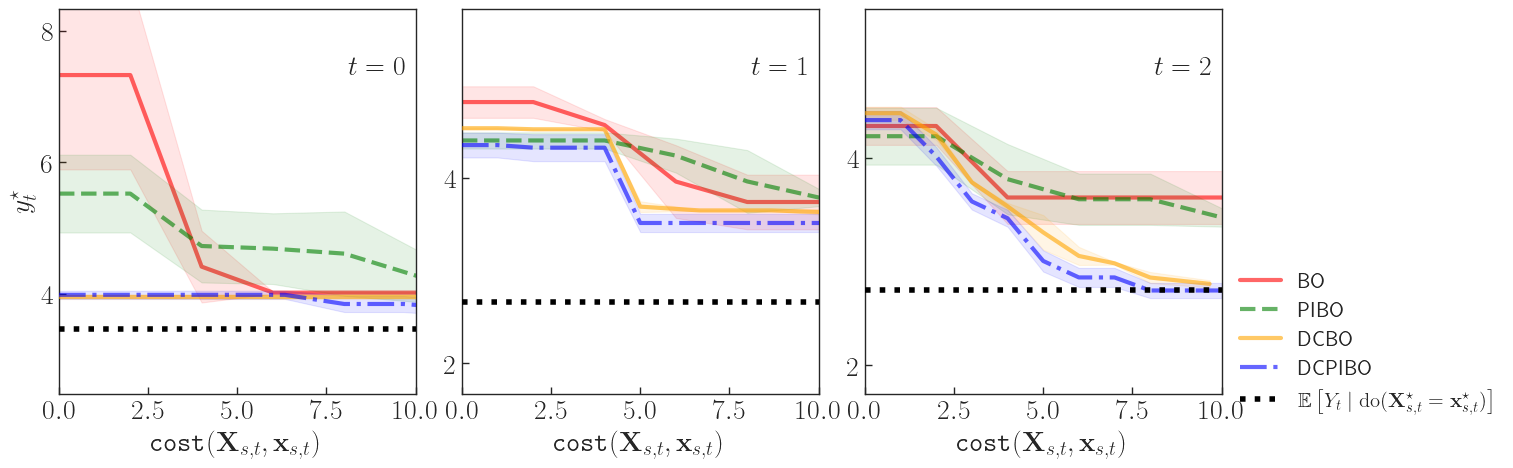

In [23]:
# Each frame corresponds to one time-slice.
plot_expected_opt_curve_paper(T,
    true_objective_values,
    good_exp_per_trial_cost,
    good_exp_optimal_outcome_values_during_trials,
    plot_params,  
    fig_size = (15,5))

### Bad prior

In [24]:
bad_data = get_relevant_results(results=bad_results, replicates=R)
bad_exp_optimal_outcome_values_during_trials, bad_exp_per_trial_cost = elaborate(number_of_interventions=None,
                                                                                 n_replicates=R,
                                                                                 data=bad_data,
                                                                                 best_objective_values=true_objective_values,
                                                                                 T=T)

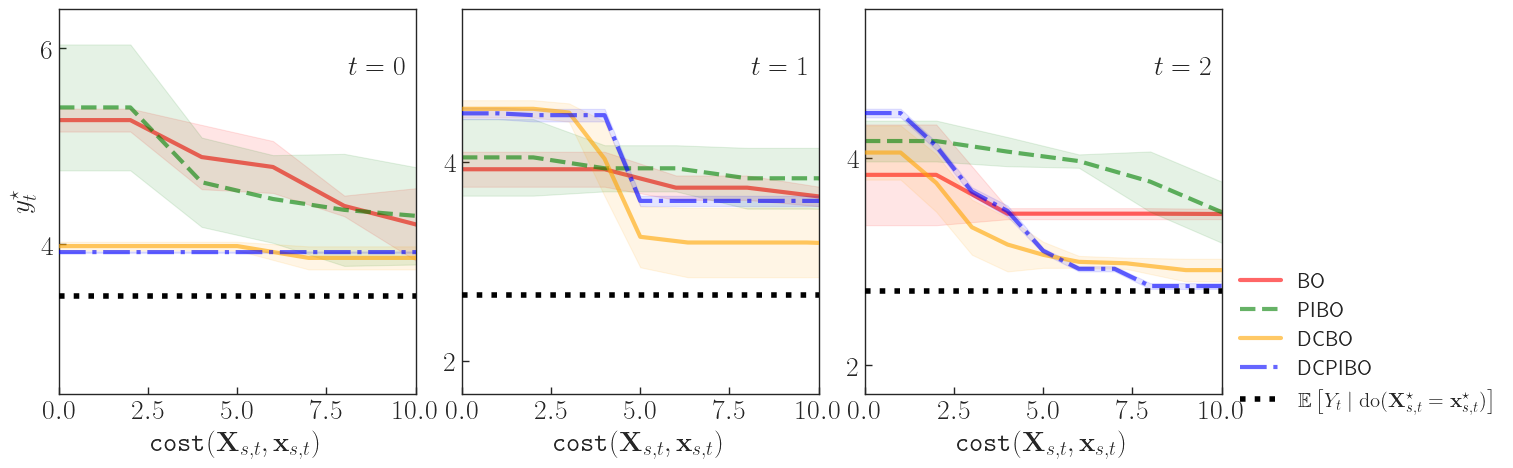

In [25]:
# Each frame corresponds to one time-slice.
plot_expected_opt_curve_paper(T,
    true_objective_values,
    bad_exp_per_trial_cost,
    bad_exp_optimal_outcome_values_during_trials,
    plot_params,  
    fig_size = (15,5))

## Gap Metric

### Good Prior's Gap Metric

In [26]:
good_t_i_l = get_common_initial_values(T=T,
                                  data=good_data,
                                  n_replicates=R)

good_w_c_d = get_converge_trial(best_objective_values=true_objective_values,
                           exp_optimal_outcome_values_during_trials=good_exp_optimal_outcome_values_during_trials,
                           n_trials=N,
                           T=T,
                           n_decimal=1)

good_summary = gap_metric_standard(T=T,
                             data=good_data,
                             best_objective_values=true_objective_values,
                             total_initial_list = good_t_i_l,
                             n_replicates=R,
                             n_trials=N,
                             where_converge_dict=good_w_c_d)

good_list = compute_gap_values(T, good_summary)

In [27]:
good_summary

{'BO': [[0.45060712035916045, 0.05695692429744886],
  [0.30521148026547246, 0.02092556057374081],
  [0.3166435496738996, 0.02782261949854764]],
 'PIBO': [[0.45657478299386733, 0.054372653351803274],
  [0.2989937483274894, 0.01501124926968395],
  [0.33118353032355086, 0.005881014935547564]],
 'DCBO': [[0.4495881866623666, 0.03667053668084981],
  [0.28965711552042633, 0.025952468245843064],
  [0.5075626578422995, 0.009713380898281993]],
 'DCPIBO': [[0.46571412712142024, 0.051194436857962974],
  [0.32001539615401914, 0.02021241588490503],
  [0.6241988383135804, 0.01043705031714814]]}

In [28]:
good_list

[0.3574873834328442,
 0.36225068721496917,
 0.41560265334169744,
 0.46997612052967325]

### Bad Prior's Gap Metric

In [29]:
bad_t_i_l = get_common_initial_values(T=T,
                                  data=bad_data,
                                  n_replicates=R)

bad_w_c_d = get_converge_trial(best_objective_values=true_objective_values,
                          exp_optimal_outcome_values_during_trials=bad_exp_optimal_outcome_values_during_trials,
                          n_trials=N,
                          T=T,
                          n_decimal=1)

bad_summary = gap_metric_standard(T=T,
                             data=bad_data,
                             best_objective_values=true_objective_values,
                             total_initial_list = bad_t_i_l,
                             n_replicates=R,
                             n_trials=N,
                             where_converge_dict=bad_w_c_d)

bad_list = compute_gap_values(T, bad_summary)

In [30]:
bad_summary

{'BO': [[0.4627450462733644, 0.018076866324943295],
  [0.3139027416243961, 0.009626856443555196],
  [0.3557361915623871, 0.021621288750968973]],
 'PIBO': [[0.44042951496468924, 0.040860454319703136],
  [0.2987858125942313, 0.021256112601739794],
  [0.34668611860804505, 0.02906653574582844]],
 'DCBO': [[0.4215929683082085, 0.04408051663172228],
  [0.38783002282641293, 0.0892342858842316],
  [0.4668518058183642, 0.033354110142984957]],
 'DCPIBO': [[0.4218827295120384, 0.023966516018784068],
  [0.270522713535234, 0.00902452740240151],
  [0.5130926713095536, 0.008564939347837076]]}

In [31]:
bad_list

[0.3774613264867159,
 0.3619671487223219,
 0.42542493231766193,
 0.4018327047856087]